# SciServer Example: Analysis of HEASARC data with minimal Machine Learning
<font size="3">Assume that we know nothing about the stellar system Eta Carinae, but want to gain a broad understanding of its behavior.  We can achieve this with very litte code and some basic machine learning techniques.</font>

In [1]:
#install packages not included the baseline
#!pip install scikit-learn
#!pip install umap-learn
#!pip install pyvo
#!pip install matplotlib

In [2]:
#!pip install tqdm

In [3]:
#necessary imports
import sys,os
import pyvo as vo
import numpy as np
from astropy.io import fits
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline  
import xspec
xspec.Xset.allowPrompting = False 

In [4]:
# Set up the catalog
tap_services=vo.regsearch(servicetype='table',keywords=['heasarc'])
heasarc_tables=tap_services[0].service.tables

<font size="3">Get the coordinates for Eta Carinae</font>

In [5]:
import astropy.coordinates as coord
pos=coord.SkyCoord.from_name("Eta Car")
## For now, have to google xtemaster to get the columns, find them here:
##  https://heasarc.gsfc.nasa.gov/W3Browse/all/xtemaster.html
##  (In future, should be a pyvo function.)
query="""SELECT target_name, cycle, prnb, obsid, time, exposure, ra, dec 
    FROM public.xtemaster as cat 
    where 
    contains(point('ICRS',cat.ra,cat.dec),circle('ICRS',{},{},0.1))=1 
    and 
    cat.exposure > 0 order by cat.time
    """.format(pos.ra.deg, pos.dec.deg)

<font size="3">Retrieve all RXTE observations of Eta Carinae</font>

In [6]:
results=tap_services[0].search(query).to_table()
results

target_name,cycle,prnb,obsid,time,exposure,ra,dec
,,,,mjd,s,deg,deg
object,int16,int32,object,float64,float64,float64,float64
ETA_CAR,1,10004,10004-01-40-00,50122.64263,1091,161.2583,-59.6800
ETA_CAR,1,10004,10004-01-39-00,50129.42992,945,161.2583,-59.6800
ETA_CAR,1,10004,10004-01-38-00,50134.57053,1018,161.2583,-59.6800
ETA_CAR,1,10004,10004-01-41-00,50142.85058,958,161.2583,-59.6800
ETA_CAR,1,10004,10004-01-37-00,50147.83134,1778,161.2583,-59.6800
ETA_CAR,1,10004,10004-01-36-00,50150.58692,696,161.2583,-59.6800
ETA_CAR,1,10004,10004-01-36-01,50154.99084,1098,161.2583,-59.6800
ETA_CAR,1,10004,10004-01-35-00,50162.75743,1109,161.2583,-59.6800


<font size="3">Collect useful information from the table</font>

In [7]:
pids=np.unique( results['cycle','prnb'])
pids

array([( 1, 10004), ( 2, 20003), ( 2, 20419), ( 3, 30006), ( 4, 40003),
       ( 5, 50003), ( 6, 60003), ( 7, 70001), ( 8, 80001), ( 9, 90004),
       (10, 91001), (11, 92001), (12, 93002), (13, 94002), (13, 94418),
       (14, 95002), (15, 96002)],
      dtype=[('cycle', '<i2'), ('prnb', '<i4')])

<font size="3">Construct a file list of all the spectra in the standard products, keep the times for later reference</font>

In [8]:
rootdir="/home/idies/workspace/headata/FTP/"
rxtedata="rxte/data/archive/"
sfilenames=[]
bfilenames=[]
rfilenames=[]
times=[]
for i in tqdm(range(pids.shape[0])):
    if not os.path.isdir(rootdir+rxtedata+'AO'+str(pids[i][0])+'/P'+str(pids[i][1])):
        print(f"Skipping {pids[i]}")
        continue
    obsdirs=os.listdir(rootdir+rxtedata+'AO'+str(pids[i][0])+'/P'+str(pids[i][1]))
    if 'FMI' in obsdirs:
        obsdirs.remove('FMI')
    for obsdir in obsdirs:
        if os.path.isdir(rootdir+rxtedata+'AO'+str(pids[i][0])+'/P'+str(pids[i][1])+'/'+obsdir+'/stdprod'):
            obsfiles=os.listdir(rootdir+rxtedata+'AO'+str(pids[i][0])+'/P'+str(pids[i][1])+'/'+obsdir+'/stdprod')
            sphafiles=[f for f in obsfiles if f.endswith('s2.pha.gz')]
            bphafiles=[f for f in obsfiles if f.endswith('b2.pha.gz')]
            rspfiles=[f for f in obsfiles if f.endswith('.rsp.gz')]
            if (len(sphafiles)==1) & (len(bphafiles)==1) & (len(rspfiles)==1):
                sfilenames.append(rootdir+rxtedata+'AO'+str(pids[i][0])+'/P'+str(pids[i][1])+'/'+obsdir+'/stdprod/'+sphafiles[0])
                bfilenames.append(rootdir+rxtedata+'AO'+str(pids[i][0])+'/P'+str(pids[i][1])+'/'+obsdir+'/stdprod/'+bphafiles[0])
                rfilenames.append(rootdir+rxtedata+'AO'+str(pids[i][0])+'/P'+str(pids[i][1])+'/'+obsdir+'/stdprod/'+rspfiles[0])
                fitsfile=fits.open(sfilenames[-1],memmap=False)
                times.append(fitsfile[0].header['TSTART'])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [03:05<00:00, 10.91s/it]


<font size="3">Change the spectra from channel space to energy space. This is especially necessary for RXTE, where the energy values of channels changed over the course of the mission.
</font>

In [9]:
pids

array([( 1, 10004), ( 2, 20003), ( 2, 20419), ( 3, 30006), ( 4, 40003),
       ( 5, 50003), ( 6, 60003), ( 7, 70001), ( 8, 80001), ( 9, 90004),
       (10, 91001), (11, 92001), (12, 93002), (13, 94002), (13, 94418),
       (14, 95002), (15, 96002)],
      dtype=[('cycle', '<i2'), ('prnb', '<i4')])

In [10]:
specs=[]

#select energy range to interpolate
#start at 2 keV due to low-resolution noise below that energy - specific to RXTE
#stop at 12 keV due to no visible activity from Eta Carinae above that energy
#step size of .1 keV

xref=np.arange(2.,12.,.1)

for src,bkg,rsp in tqdm(zip(sfilenames,bfilenames,rfilenames)):
    xspec.AllData.clear()  # clear out any previously loaded dataset
    s = xspec.Spectrum(src) 
    s.background=bkg
    s.response=rsp
    xspec.Plot.area=True;
    xspec.Plot.xAxis = "keV";
    xspec.Plot.add = True;
    xspec.Plot("data");
    xspec.Plot.background = True;
    xVals = xspec.Plot.x();
    yVals = xspec.Plot.y();
    yref= np.interp(xref, xVals, yVals); 
    specs.append(yref);

specs=np.array(specs)

1368it [03:06,  7.35it/s]


<font size="3">Plot the collected spectra
</font>

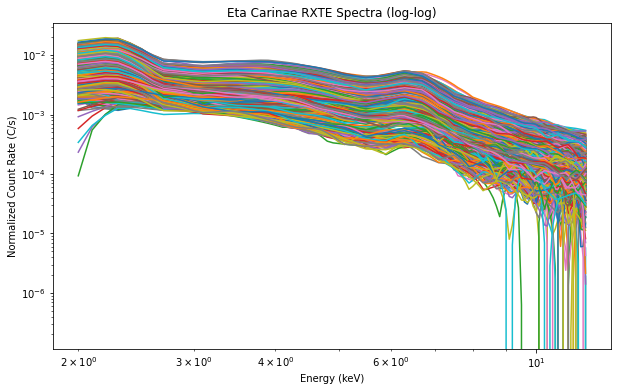

In [11]:
xvals=np.tile(xref,(specs.shape[0],1))
plt.figure(figsize=(10,6));
plt.plot(xvals.T,specs.T);
plt.semilogx();
plt.semilogy();
plt.xlabel('Energy (keV)');
plt.ylabel('Normalized Count Rate (C/s)');
plt.title('Eta Carinae RXTE Spectra (log-log)');

<font size="3">Here we start the ML work.  Scale the spectra in order to compare the behavior, not the magnitude. Note that after applying the scaler, log-log plots will be nonsensical, so we will only plot on a linear scale
</font>

In [12]:
from sklearn.preprocessing import StandardScaler

scaled_specs=[]
for i in tqdm(range(specs.shape[0])):
    s=StandardScaler()
    scaled_specs.append(s.fit_transform(specs[i].reshape(-1,1)).T[0])
scaled_specs=np.array(scaled_specs)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1368/1368 [00:01<00:00, 874.03it/s]


<font size="3">Plot the scaled and unscaled spectra for comparison</font>

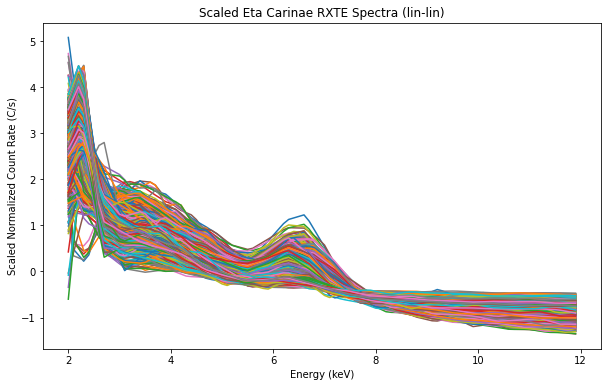

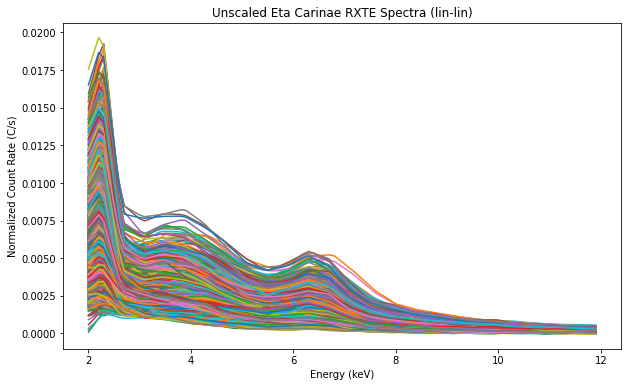

In [13]:
plt.figure(figsize=(10,6));
plt.plot(xvals.T,scaled_specs.T);
plt.xlabel('Energy (keV)');
plt.ylabel('Scaled Normalized Count Rate (C/s)');
plt.title('Scaled Eta Carinae RXTE Spectra (lin-lin)');

plt.figure(figsize=(10,6));
plt.plot(xvals.T,specs.T);
plt.xlabel('Energy (keV)');
plt.ylabel('Normalized Count Rate (C/s)');
plt.title('Unscaled Eta Carinae RXTE Spectra (lin-lin)');

<font size="3">Note that the scaled spectra all have a similiar shape AND magnitude, whereas the unscaled spectra have a similar shape but not mangitude.
Scaling has the effect of making big features smaller, but small features bigger. So, let's cut off the spectra at 9 keV in order to avoid noise driving the analysis, then rescale.</font>

In [14]:
specs=specs[:,:xref[xref<=9.0001].shape[0]]
xref=xref[:xref[xref<=9.0001].shape[0]]

scaled_specs=[]
for i in tqdm(range(specs.shape[0])):
    s=StandardScaler()
    scaled_specs.append(s.fit_transform(specs[i].reshape(-1,1)).T[0])
scaled_specs=np.array(scaled_specs)    

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1368/1368 [00:01<00:00, 910.53it/s]


<font size="3">Plot the scaled and unscaled spectra for comparison</font>

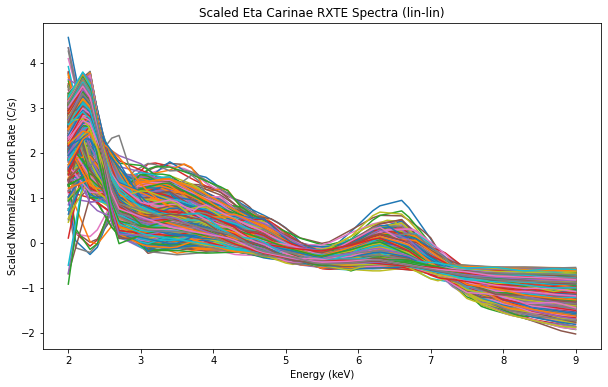

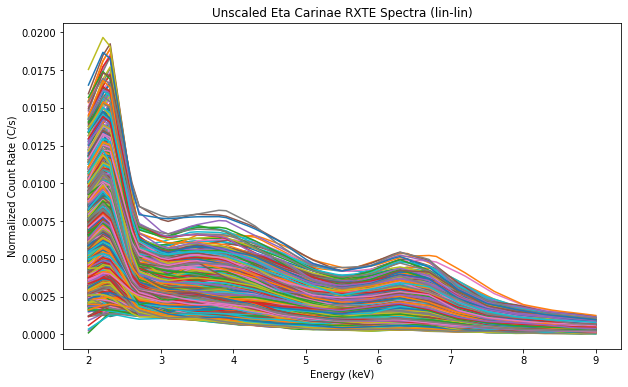

In [15]:
xvals=np.tile(xref,(specs.shape[0],1))
plt.figure(figsize=(10,6));
plt.plot(xvals.T,scaled_specs.T);
plt.xlabel('Energy (keV)');
plt.ylabel('Scaled Normalized Count Rate (C/s)');
plt.title('Scaled Eta Carinae RXTE Spectra (lin-lin)');

plt.figure(figsize=(10,6));
plt.plot(xvals.T,specs.T);
plt.xlabel('Energy (keV)');
plt.ylabel('Normalized Count Rate (C/s)');
plt.title('Unscaled Eta Carinae RXTE Spectra (lin-lin)');

<font size="3">Great! The scaled spectra are now ready for analysis.  Let's see how Principal Component Analysis interprets the spectra in two dimensions...</font>

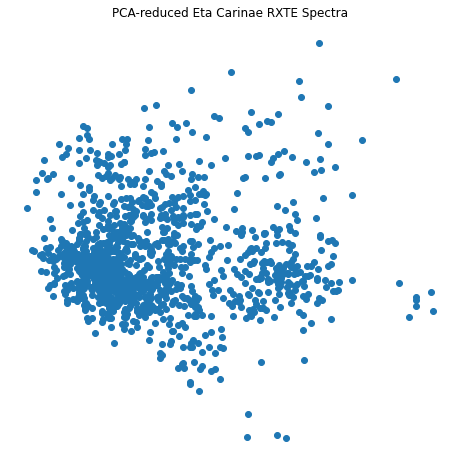

In [16]:
from sklearn.decomposition import PCA

# For comparison, compute PCA
pca=PCA(n_components=2)
scaled_specs_pca=pca.fit_transform(scaled_specs)
plt.figure(figsize=(8,8))
plt.scatter(scaled_specs_pca[:,0],scaled_specs_pca[:,1]);
plt.title('PCA-reduced Eta Carinae RXTE Spectra');
plt.axis('off');

<font size="3">PCA preserves distance, but has no concept of high-dimensional groupings.  For comparison, compute TSNE, which can extract local high-dimensional relationships.
</font>

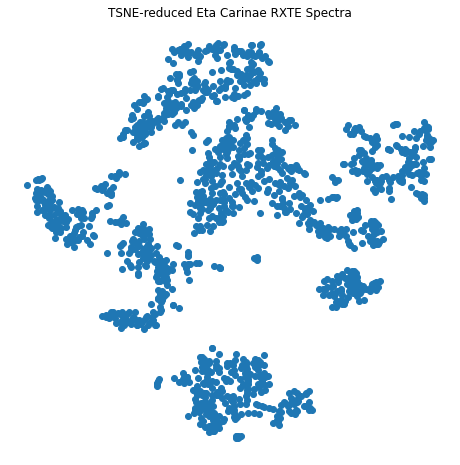

In [17]:
from sklearn.manifold import TSNE

tsne=TSNE(n_components=2)
scaled_specs_tsne=tsne.fit_transform(scaled_specs)
plt.figure(figsize=(8,8))
plt.scatter(scaled_specs_tsne[:,0],scaled_specs_tsne[:,1]);
plt.title('TSNE-reduced Eta Carinae RXTE Spectra');
plt.axis('off');

<font size="3">TSNE indeed finds some local groupings, so let's check UMAP, which will allow us to understand local and global relationships.
</font>

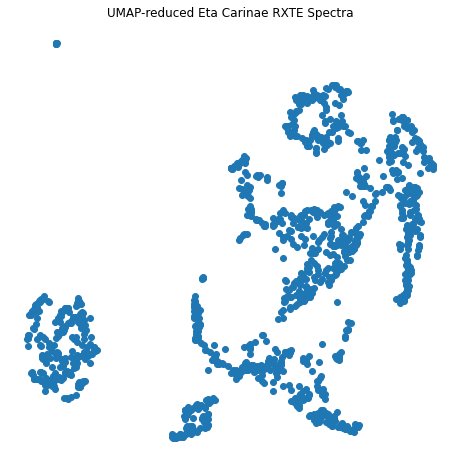

In [18]:
from umap import UMAP

um=UMAP(random_state=1)
scaled_specs_umap=um.fit_transform(scaled_specs)
plt.figure(figsize=(8,8))
plt.scatter(scaled_specs_umap[:,0],scaled_specs_umap[:,1]);
plt.title('UMAP-reduced Eta Carinae RXTE Spectra');
plt.axis('off');

<font size="3">PCA only represents distance between the high dimensional samples whereas TSNE can find local groupings.
UMAP combines the two into a more intelligent representation that understands both local and global distance.
Let's cluster the UMAP representation using DBSCAN....
</font>

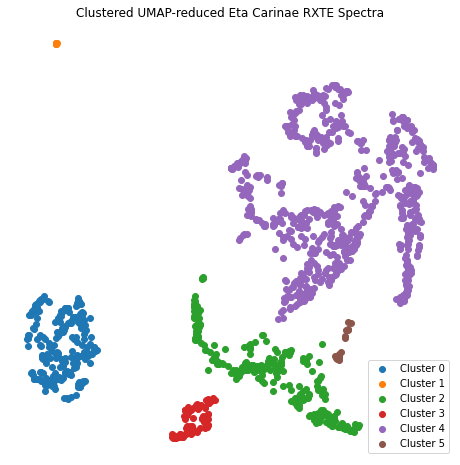

In [19]:
from sklearn.cluster import DBSCAN

dbs=DBSCAN(eps=.6,min_samples=2)
clusters=dbs.fit(scaled_specs_umap)
labels=np.unique(clusters.labels_)
plt.figure(figsize=(8,8))
for i in range(len(np.unique(labels[labels>=0]))):
    plt.scatter(scaled_specs_umap[clusters.labels_==i,0],scaled_specs_umap[clusters.labels_==i,1],label='Cluster '+str(i));
plt.legend()
plt.title('Clustered UMAP-reduced Eta Carinae RXTE Spectra');
plt.axis('off');

<font size="3">The DBSCAN clustering produced some interesting groupings - we should examine the spectra of each group.
For a less crowded plot of the spectra clusters, plot the mean spectrum of each cluster.
</font>

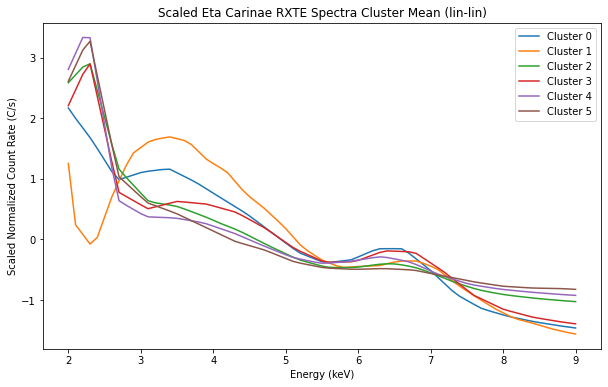

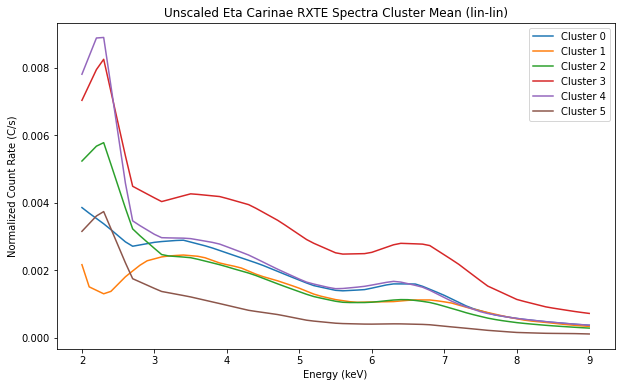

In [20]:
# Plot the scaled spectra mean
plt.figure(figsize=(10,6))
for i in range(len(np.unique(labels[labels>=0]))):
    plt.plot(xref,scaled_specs[clusters.labels_==i].mean(axis=0),label='Cluster '+str(i))
plt.legend();
plt.xlabel('Energy (keV)');
plt.ylabel('Scaled Normalized Count Rate (C/s)');
plt.title('Scaled Eta Carinae RXTE Spectra Cluster Mean (lin-lin)');

# Plot the unscaled spectra mean
plt.figure(figsize=(10,6))
for i in range(len(np.unique(labels[labels>=0]))):
    plt.plot(xref,specs[clusters.labels_==i].mean(axis=0),label='Cluster '+str(i))
plt.legend();
plt.xlabel('Energy (keV)');
plt.ylabel('Normalized Count Rate (C/s)');
plt.title('Unscaled Eta Carinae RXTE Spectra Cluster Mean (lin-lin)');


<font size="3">
Clearly, the strangest spectra belong to cluster 1 (orange).
How many spectra are in this group?
</font>

In [21]:
scaled_specs[clusters.labels_==1].shape[0]

7

<font size="3">
So, we can say that this group is not likely an isolated incident caused by mechanical malfunction
since similar spectra occur in seven different observations.  Let's look at the overall light curve to see where these odd spectra are occuring.

</font>

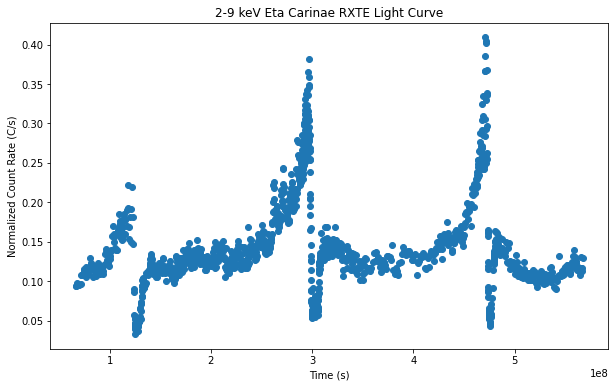

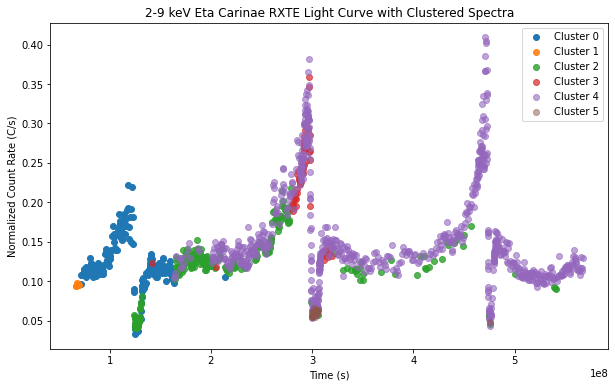

In [22]:
# Sum the count rate across the energy range
specsum=specs.sum(axis=1)

# plot the overall light curve
plt.figure(figsize=(10,6))
plt.scatter(times,specsum)
plt.xlabel('Time (s)');
plt.ylabel('Normalized Count Rate (C/s)');
plt.title('2-9 keV Eta Carinae RXTE Light Curve');


# plot the clustered light curve
plt.figure(figsize=(10,6))
for i in range(len(np.unique(labels[labels>=0]))):
    plt.scatter(np.array(times)[clusters.labels_==i],specsum[clusters.labels_==i],label='Cluster '+str(i),alpha=1-.1*i)
plt.xlabel('Time (s)');
plt.ylabel('Normalized Count Rate (C/s)');
plt.title('2-9 keV Eta Carinae RXTE Light Curve with Clustered Spectra');
plt.legend();

<font size="3">
We can see that the orange group occurred near the beginning of the RXTE mission.
Let's take a closer look...
</font>

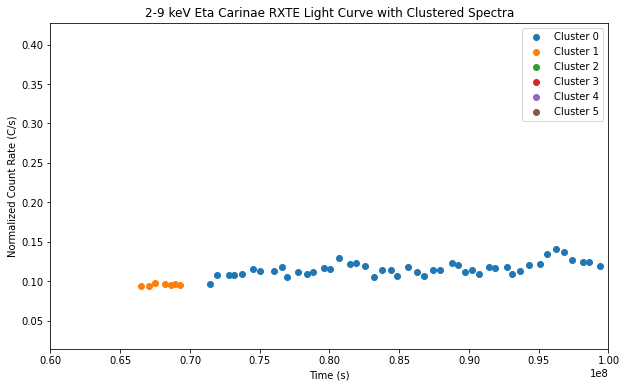

In [23]:
# plot the clustered light curve
plt.figure(figsize=(10,6))
for i in range(len(np.unique(labels[labels>=0]))):
    plt.scatter(np.array(times)[clusters.labels_==i],specsum[clusters.labels_==i],label='Cluster '+str(i))
plt.xlabel('Time (s)');
plt.ylabel('Normalized Count Rate (C/s)');
plt.title('2-9 keV Eta Carinae RXTE Light Curve with Clustered Spectra');
plt.legend();
plt.xlim(.6e8,1e8);

<font size="3">
Indeed, the orange group were the first seven observations of Eta Car from RXTE.
Given that this type of spectra does not repeat again, the earlier hypothesis that these
spectra are not due to mechanical issues must be revisted.
Also, given that the blue group also lacks the 2-3 keV noise peak and is only located toward 
the beginning of the mission, it may be the case that the background estimation from 
that period of time differs substantially.

So, what else is interesting?
Cluster 5 (the brown group) occurs exclusively at the overall light curve minima.
Looking again at the unscaled spectra means:
</font>

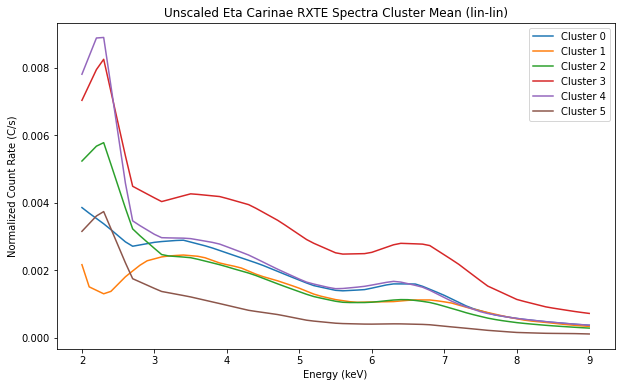

In [24]:
# Plot the unscaled spectra mean
plt.figure(figsize=(10,6))
for i in range(len(np.unique(labels[labels>=0]))):
    plt.plot(xref,specs[clusters.labels_==i].mean(axis=0),label='Cluster '+str(i))
plt.legend();
plt.xlabel('Energy (keV)');
plt.ylabel('Normalized Count Rate (C/s)');
plt.title('Unscaled Eta Carinae RXTE Spectra Cluster Mean (lin-lin)');

<font size="3">
We can see that the broad peak associated with the 3-5 keV energy range is completely absent from the brown group.
Since this phenomena is documented at both X-ray minimums from the latter part of the mission (the earlier minimum may
be skewed by background estimation as well) we can say that this spectral difference is likely due to a substantial change
in the nature of the Eta Carina stellar system at this time.


Also interesting is the Green and Purple group relationship.  Let's exlude the earlier measurements, where we suspect the background
estimation may be wrong, and show the overall light curve again:

</font>

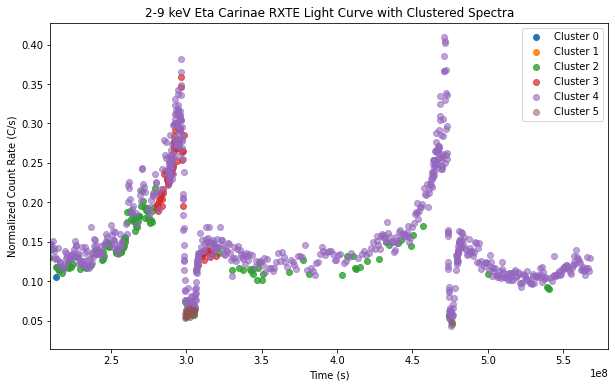

In [25]:
plt.figure(figsize=(10,6))
for i in range(len(np.unique(labels[labels>=0]))):
    plt.scatter(np.array(times)[clusters.labels_==i],specsum[clusters.labels_==i],label='Cluster '+str(i),alpha=1-.1*i)
plt.xlabel('Time (s)');
plt.ylabel('Normalized Count Rate (C/s)');
plt.title('2-9 keV Eta Carinae RXTE Light Curve with Clustered Spectra');
plt.legend();
plt.xlim(2.1e8,5.8e8);

<font size="3">
The green group, which has a lower 3-5 keV peak and a slightly higher energy peak in the 6-7 keV range than the purple group, 
appears to occur in conjunction with the purple group.  This may indicate the presence of two competing behaviors.
</font>

<font size="3">With very little code, we have now gained a basic understanding of Eta Carinae from a minimal analysis of HEASARC data.</font>